# Komplettes Feature-Modell mit der DIM-Toolbox

Ziel des Tutorials ist den Workflow zur Identifikation von Feature-Modellen für den Spritzgießprozess mit der DIM-Toolbox zu veranschaulichen.

Die für das Modelltraining (Schätzung der Modellparameter) und die Modellvalidierung verwendeten Daten wurden im Rahmen eines umfangreichen Versuchsplanes erhoben. Der Trainingsdatensatz umfasst die Daten von 2105 Produktionszyklen, der Validierungsdatensatz umfasst die Daten von 548 Produktionszyklen.

In [10]:
import pickle as pkl
import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, "/home/alexander/GitHub/DigitalTwinInjectionMolding/")
sys.path.insert(0, 'E:/GitHub/DigitalTwinInjectionMolding/')

from DIM.miscellaneous.PreProcessing import LoadFeatureData,LoadSetpointData,MinMaxScale
from DIM.models.model_structures import Static_MLP
from DIM.optim.param_optim import ModelTraining, static_mode
from DIM.optim.common import BestFitRate

Spezifiziere Pfad zur Datenbasis und welche Chargen für Modellbildung und -validierung verwendet werden sollen 

In [11]:
path = 'E:/GitHub/DigitalTwinInjectionMolding/data/Versuchsplan/normalized/'
charges = list(range(1,275))
split = 'all' 

Spezifiziere Ein- und Ausgangsgrößen für Prozess- und Qualitätsmodell

In [12]:
u_label_p = ['Düsentemperatur', 'Werkzeugtemperatur', 'Einspritzgeschwindigkeit',
  'Umschaltpunkt', 'Nachdruckhöhe', 'Nachdruckzeit', 'Staudruck', 'Kühlzeit']

u_label_q = ['T_wkz_0', 'T_wkz_max', 't_Twkz_max', 'T_wkz_int', 'p_wkz_max',
'p_wkz_int', 'p_wkz_res', 't_pwkz_max']                                         # = y_label_p

y_label_q = ['Durchmesser_innen']

Die Funktion LoadFeatureData() berechnet aus den Prozessgrößen jedes Spritzgießzykluses teilt die abgelegten Daten in Trainings- und Validierungsdaten ein

In [13]:
data_train,data_val = LoadFeatureData(path,charges,split)

Es ist insbesondere bei der Verwendung Neuronaler Netze zweckmäßig, die Daten auf das Intervall [-1,1] zu skalieren, das geschieht mittels der Funktion MinMaxScale()

In [14]:
data_train,minmax = MinMaxScale(data_train,u_label_q+u_label_p+y_label_q)
data_val,_ = MinMaxScale(data_val,u_label_q+u_label_p+y_label_q,minmax)

Ein Neuronales Netz, welches Eingangsgrößen statisch auf Ausgangsgrößen abbildet ist Static_MLP. Bei der Erzeugung einer Instanz der Klasse Static_MLP müssen einige Parameter festgelegt werden:

| Parameter | Typ | Erläuterung |
| --- | --- | :-- |
|dim_u : |int |Anzahl an Modelleingängen |
|dim_hidden | int | Anzahl der Modellausgänge |
|u_label| list of str |Namen der Eingangsgrößen, muss mit den Spaltenüberschriften in data_train, data_val übereinstimmen|
|y_label| list of str |Namen der Ausgangsgrößen, muss mit den Spaltenüberschriften in data_train, data_val übereinstimmen|
|name | str | Name des Modells, wird verwendet, um Modellparameter eindeutig zu identifizieren und bspw. von den Parametern anderer Instanzen der gleichen Klasse zu unterscheiden|
|init_proc | str | Prozedur, die bei der Initialisierung der Modellparameter angewendet werden soll. Implementiert sind 'random', 'xavier' und 'he'|


In [15]:
model_p = Static_MLP(dim_u=8, dim_out=8, dim_hidden=40,u_label=u_label_p,
                    y_label=u_label_q,name='proc', init_proc='xavier')

model_q = Static_MLP(dim_u=8, dim_out=1, dim_hidden=10,u_label=u_label_q,
                    y_label=y_label_q,name='qual', init_proc='xavier')

Anschließend werden die bereits vorhandenen Optimierungsergebnisse geladen

In [16]:
result_p = pkl.load(open('results_p_process_stationary_40dim.pkl','rb'))
result_q =  pkl.load(open('results_q_feature_trans.pkl','rb'))

Und die Parameter, welche das beste Ergebnis auf den Validierungsdaten ergeben haben, dem Prozess- und Qualitätsmodell zugewiesen

In [17]:
model_p.Parameters = result_p.loc[4,'params_val']
model_q.Parameters = result_q.loc[3,'params_val']

Der Spritzgießprozess wird nun durch ein Prozessmodell model_p und ein Qualitätsmodell model_q beschrieben. Um die Bauteilqualität im laufenden Betrieb zu prädizieren, muss zuerst das Prozessmodell ausgewertet werden, und dessen Prädiktion als Eingang für das Qualitätsmodell genutzt werden. Dies wird im folgenden anhand der Validierungsdaten veranschaulicht:

In [18]:
_,prediction_p = static_mode(model_p,data_val)
_,prediction_q = static_mode(model_q,prediction_p)

Die Bauteilqualität prediction_q wurde nun nur basierend auf den eingestellten Maschinenparametern ermittelt, ohne Verwendung der gemessenen Prozessgrößen(-features).

Um die Modellgüte zu beurteilen kann die Best Fit Rate berechnet werden:

In [19]:
print(BestFitRate(data_val[y_label_q].values, prediction_q[y_label_q].values))

81.34175160813814


Durch Gegenüberstellung der bekannten wahren Bauteilqualität mit der prädizierten Bauteilqualität kann das Ergebnis visualisiert werden:

<AxesSubplot:ylabel='Durchmesser_innen'>

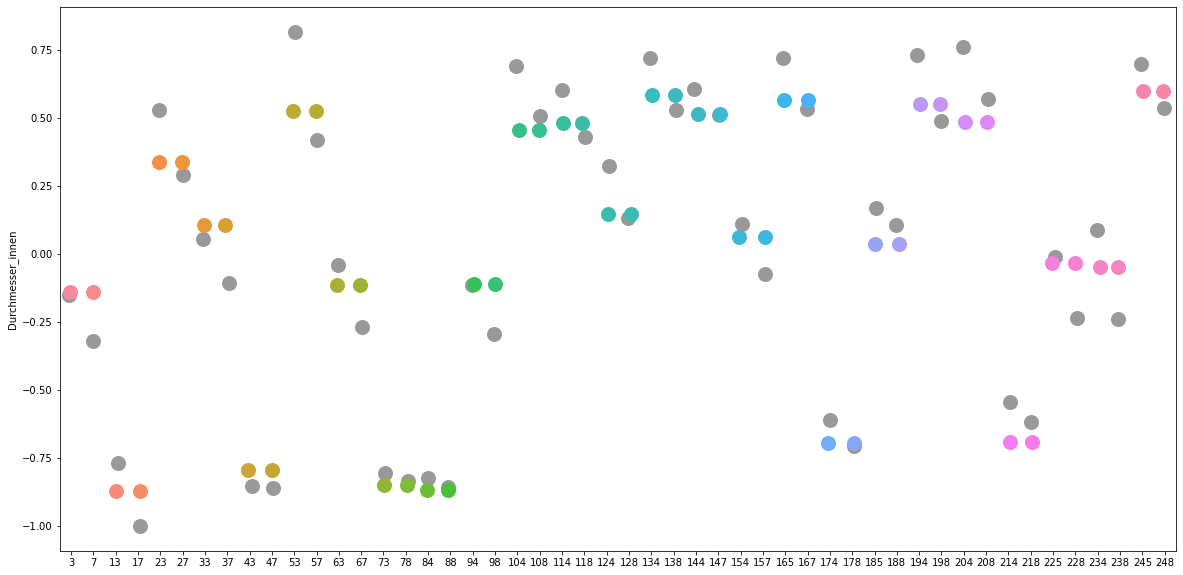

In [22]:
fig, ax = plt.subplots(figsize=(20, 10))
idx_plot = data_val.index[0:50]
sns.stripplot(x=idx_plot,y=data_val.loc[idx_plot,'Durchmesser_innen'],color='grey',alpha=.8,size=15,ax=ax)
sns.stripplot(x=idx_plot,y=prediction_q.loc[idx_plot,'Durchmesser_innen'],size=15,ax=ax)